# Implementation of LSTM : Text generation

LSTMs can be seen as a more complex and capable family of RNNs. Though LSTMs are a complicated beast, the underlying principles of LSTMs are as same as those of RNNs; they process a sequence of items by working on one input at a time in a sequential order. An LSTM is mainly composed of five different components:

1. Cell state: This is the internal cell state (that is, memory) of an LSTM cell.

2. Hidden state: This is the external hidden state exposed to other layers and used to calculate predictions.

3. Input gate: This determines how much of the current input is read into the cell state.

4. Forget gate: This determines how much of the previous cell state is sent into the current cell state.

5. Output gate: This determines how much of the cell state is output into the hidden state.

LSTMs can decide when to add, update, or forget information stored in each neuron in the cell state. In other words, LSTMs are equipped with a mechanism to keep the cell state unchanged (if warranted for better performance), giving them the ability to store long-term dependencies.

This is achieved by introducing a gating mechanism. LSTMs possess gates for each operation the cell needs to perform. The gates are continuous (often sigmoid functions) between 0 and 1, where 0 means no information flows through the gate, and 1 means all the information flows through the gate. An LSTM uses one such gate for each neuron in the cell. As explained above, these gates control the following:

1. How much of the current input is written to the cell state (input gate)

2. How much information is forgotten from the previous cell state (forget gate)

3. How much information is output into the final hidden state from the cell state (output gate)


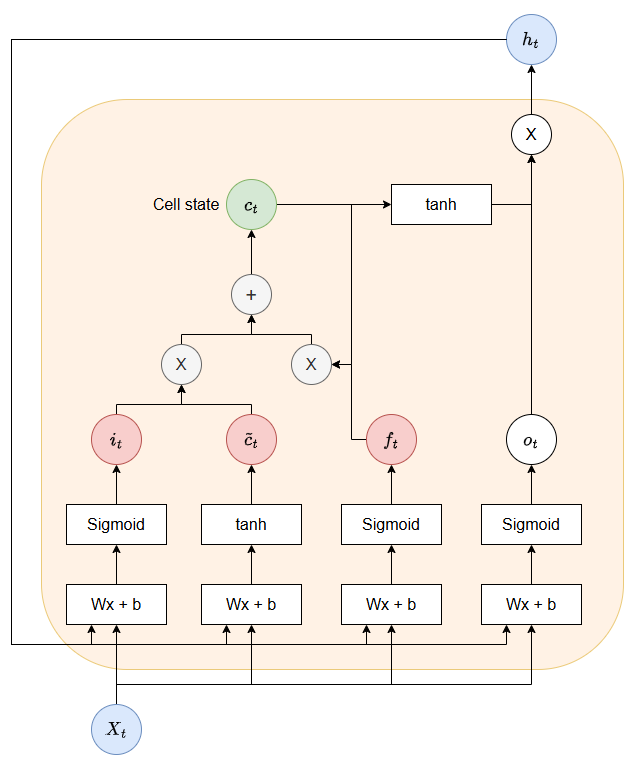

# 1. Import Necessary Libraries

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
from six.moves.urllib.request import urlretrieve
import tensorflow as tf

# 2. Downloading stories

First, we need to understand what the dataset looks like so that when we see the generated text, we can assess whether it makes sense, given the training data. We’ll download the first 100 books from “Grimms’ Fairy Tales.” These are translations of a set of books (from German to English) by the Grimm brothers.

In [ ]:
url = 'https://www.cs.cmu.edu/~spok/grimmtmp/'
dir_name = 'data'

def download_data(url, filename, download_dir):
    """Download a file if not present, and make sure it's the right size."""

    # Create directories if they don't exist.
    os.makedirs(download_dir, exist_ok=True)

    # If file doesn't exist, download
    if not os.path.exists(os.path.join(download_dir,filename)):
        filepath, _ = urlretrieve(url + filename, os.path.join(download_dir,filename))
    else:
        filepath = os.path.join(download_dir, filename)

    return filepath

# Number of files and their names to download
# num_files = 209
num_files = 100
filenames = [format(i, '03d')+'.txt' for i in range(1,num_files+1)]

# Download each file
for fn in filenames:
    download_data(url, fn, dir_name)

# Check if all files are downloaded
for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name,filenames[i]))
    assert file_exists
print(f"{len(filenames)} files found.")

100 files found.


# 3. Splitting train, validation, and test data

We’ll separate the stories we downloaded into three sets: training, validation, and test files. We’ll use the content in each set of files as the training, validation, and test data. We’ll use scikit-learn’s train_test_split() function to do so.

The train_test_split() function takes an iterable (e.g., list, tuple, array, etc.) as an input and splits it into two sets based on a defined split ratio. In this case, the input is a list of filenames, and we first make a split of 80%–20% training and [validation + test] data. Then, we further split the test_and_valid_filenames 50%–50% to generate test and validation sets. Note how we also pass a random seed to the train_test_split function to make sure we get the same split over multiple runs.

In [ ]:
from sklearn.model_selection import train_test_split

# Fix the random seed so we get the same output every time
random_state = 54321

filenames = [os.path.join(dir_name, f) for f in os.listdir(dir_name)]

# First separate train and valid+test data
train_filenames, test_and_valid_filenames = train_test_split(filenames, test_size=0.2, random_state=random_state)

# Separate valid+test data to validation and test data
valid_filenames, test_filenames = train_test_split(test_and_valid_filenames, test_size=0.5, random_state=random_state)

# Print out the sizes and some sample file names
for subset_id, subset in zip(('train', 'valid', 'test'), (train_filenames, valid_filenames, test_filenames)):
    print(f"Got {len(subset)} files in the {subset_id} dataset (e.g. {subset[:3]})")

Got 80 files in the train dataset (e.g. ['data/098.txt', 'data/025.txt', 'data/070.txt'])
Got 10 files in the valid dataset (e.g. ['data/008.txt', 'data/076.txt', 'data/085.txt'])
Got 10 files in the test dataset (e.g. ['data/069.txt', 'data/062.txt', 'data/043.txt'])


# 4. Finding the vocabulary size

We’ll be using bigrams (i.e., n-grams with n=2) to train our language model. That is, we’ll split the story into units of two characters. Furthermore, we will convert all characters to lowercase to reduce the input dimensionality. Using character-level bigrams helps us to language model with a reduced vocabulary, leading to faster model training. For example:

The king was hunting in the forest.

The sentence above would break down into a sequence of bigrams as follows:

['th', 'e', 'ki', 'ng', 'w', 'as', ...]

Let’s find out how large the vocabulary is. For that, we first define a set object. Next, we go through each training file, read the content, and store that as a string in the variable document.

Finally, we update the set object with all the bigrams in the string containing each story. We get the bigrams by traversing the string two characters at a time:

In [ ]:
bigram_set = set()

# Go through each file in the training set
for fname in train_filenames:
    document = [] # This will hold all the text
    with open(fname, 'r') as f:
        for row in f:
            # Convert text to lower case to reduce input dimensionality
            document.append(row.lower())

        # From the list of text we have, generate one long string (containing all training stories)
        document = " ".join(document)

        # Update the set with all bigrams found
        bigram_set.update([document[i:i+2] for i in range(0, len(document), 2)])

# Assign to a variable and print
n_vocab = len(bigram_set)
print(f"Found {n_vocab} unique bigrams")

Found 674 unique bigrams


# 5. Reading data and generating batches for the model (tf.data API)

We’ll now define a fully fledged data pipeline that is capable of reading the files from the disk and transforming the content into a format or structure that can be used to train the model. The tf.data API in TensorFlow allows us to define data pipelines that can manipulate data in specific ways to suit machine learning models. For that, we’ll define a function called generate_tf_ dataset() that takes:

filenames: A list of file names containing the text to be used for the model.

ngram_width: Width of the n-grams to be extracted.

window_size: Length of the sequence of n-grams to be used to generate a single data point for the model.

batch_size: Size of the batch.

shuffle: Whether to shuffle the data. Defaults to False.

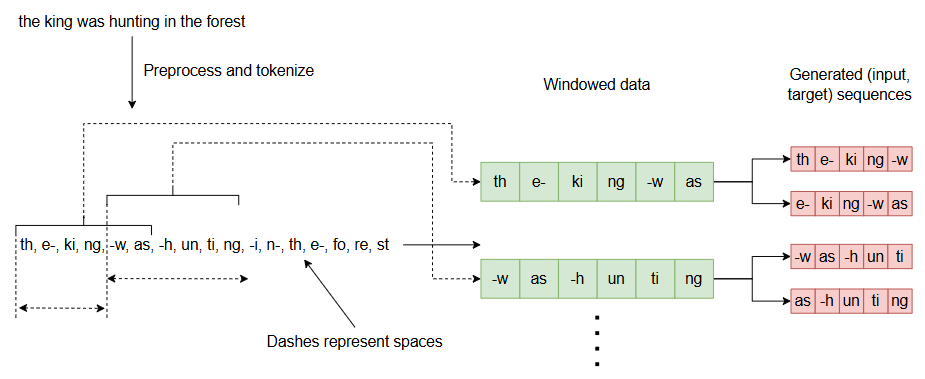

In [ ]:
def generate_tf_dataset(filenames, ngram_width, window_size, batch_size, shuffle=False):
    """ Generate batched data from a list of files speficied """

    # Read the data found in the documents
    documents = []
    for f in filenames:
        doc = tf.io.read_file(f)
        doc = tf.strings.ngrams(    # Generate n-grams from the string
            tf.strings.bytes_split(    # Create a list of chars from a string
                tf.strings.regex_replace(    # Replace new lines with space
                    tf.strings.lower(    # Convert string to lowercase
                        doc
                    ), "\n", " "
                )
            ),
            ngram_width, separator=''
        )
        documents.append(doc.numpy().tolist())

    # document is a list of list of strings, where each string is a story
    # From that we generate a ragged tensor
    documents = tf.ragged.constant(documents)
    # Create a dataset where each row in the ragged tensor would be a sample
    doc_dataset = tf.data.Dataset.from_tensor_slices(documents)
    # We need to perform a quick transformation - tf.strings.ngrams would generate
    # all the n-grams (e.g., abcd -> ab, bc, cd) with overlap; however, for our data
    # we do not need the overlap, so we need to skip the overlapping n-grams
    # the following line does that
    doc_dataset = doc_dataset.map(lambda x: x[::ngram_width])

    # Here we are using a window function to generate windows from text
    # For a text sequence with window_size 3 and shift 1 you get
    # e.g., ab, cd, ef, gh, ij, ... -> [ab, cd, ef], [cd, ef, gh], [ef, gh, ij], ...
    # each of these windows is a single training sequence for our model
    doc_dataset = doc_dataset.flat_map(
        lambda x: tf.data.Dataset.from_tensor_slices(
            x
        ).window(
            size=window_size+1, shift=int(window_size * 0.75)
        ).flat_map(
            lambda window: window.batch(window_size+1, drop_remainder=True)
        )
    )

    # From each windowed sequence we generate, input and target tuple
    # e.g. [ab, cd, ef] -> ([ab, cd], [cd, ef])
    doc_dataset = doc_dataset.map(lambda x: (x[:-1], x[1:]))

    # Shuffle the data if required
    doc_dataset = doc_dataset.shuffle(buffer_size=batch_size*10) if shuffle else doc_dataset

    # Batch the data
    doc_dataset = doc_dataset.batch(batch_size=batch_size)

    # Return the data
    return doc_dataset


ngram_length = 2
batch_size = 128
window_size = 128

train_ds = generate_tf_dataset(train_filenames, ngram_length, window_size, batch_size, shuffle=True)
valid_ds = generate_tf_dataset(valid_filenames, ngram_length, window_size, batch_size)
test_ds = generate_tf_dataset(test_filenames, ngram_length, window_size, batch_size)


# 6. Generating a few samples from the dataset function

In [ ]:
ds = generate_tf_dataset(train_filenames, 2, window_size=10, batch_size=1).take(5)

for record in ds:
    print(record[0].numpy(), '->', record[1].numpy())

[[b'th' b'er' b'e ' b'wa' b's ' b'on' b'ce' b' a' b' p' b'oo']] -> [[b'er' b'e ' b'wa' b's ' b'on' b'ce' b' a' b' p' b'oo' b'r ']]
[[b' a' b' p' b'oo' b'r ' b'ma' b'n ' b'wh' b'o ' b'ha' b'd ']] -> [[b' p' b'oo' b'r ' b'ma' b'n ' b'wh' b'o ' b'ha' b'd ' b'fo']]
[[b'o ' b'ha' b'd ' b'fo' b'ur' b' s' b'on' b's,' b' a' b'nd']] -> [[b'ha' b'd ' b'fo' b'ur' b' s' b'on' b's,' b' a' b'nd' b' w']]
[[b's,' b' a' b'nd' b' w' b'he' b'n ' b'th' b'ey' b' w' b'er']] -> [[b' a' b'nd' b' w' b'he' b'n ' b'th' b'ey' b' w' b'er' b'e ']]
[[b'ey' b' w' b'er' b'e ' b'gr' b'ow' b'n ' b'up' b', ' b'he']] -> [[b' w' b'er' b'e ' b'gr' b'ow' b'n ' b'up' b', ' b'he' b' s']]


we can see that the target sequence is just the input sequence shifted one to the right. The b in front of the characters denotes that the characters are stored as bytes.

# 7. Defining the model


In [ ]:
import tensorflow.keras.backend as K

K.clear_session()
tf.compat.v1.reset_default_graph()

# 8. Defining a TextVectorization layer

The TextVectorization layer provides us with a convenient way to integrate text tokenization (i.e., converting strings into a list of tokens that are represented by integer IDs) into the model as a layer.

Note that we are defining several important arguments, such as the max_tokens (size of the vocabulary), the standardize argument to not perform any text preprocessing, the split argument to not perform any splitting, and finally, the input_shape argument to inform the layer that the input will be a batch of sequences of n-grams. With that, we have to train the text vectorization layer to recognize the available n-grams and map them to unique IDs. We can simply pass our training tf.data pipeline to this layer to learn the n-grams.

In [ ]:
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

# The vectorization layer that will convert string bigrams to IDs
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=n_vocab, standardize=None,
    split=None, input_shape=(window_size,)
)

# Train the model on existing data
text_vectorizer.adapt(train_ds)

In [ ]:
# Print a few bigrams learned by the vectorization layer
text_vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'e ', 'he', ' t', 'th', 'd ', ' a', ', ', ' h']

# 9. Converting the targets from string n-grams to n-gram IDs

Once the TextVectorization layer is trained, we have to modify our training, validation, and testing data pipelines slightly. Remember that our data pipelines output sequences of n-gram strings as inputs and targets. We need to convert the target sequences to sequences of n-gram IDs so that a loss can be computed. For that, we’ll simply pass the targets in the datasets through the text_vectorizer layer using the tf.data.Dataset.map() functionality

In [ ]:
train_ds = train_ds.map(lambda x, y: (x, text_vectorizer(y)))
valid_ds = valid_ds.map(lambda x, y: (x, text_vectorizer(y)))
test_ds = test_ds.map(lambda x, y: (x, text_vectorizer(y)))

# 10. Defining the LSTM model

Our model will have:

The previously trained TextVectorization layer.

An embedding layer is randomly initialized and jointly trained with the model.

Two LSTM layers, each with 512 and 256 nodes, respectively.

A fully connected hidden layer with 1,024 nodes and ReLU activation.

The final prediction layer with n_vocab nodes and softmax activation.

We start by calling K.clear_session(), which is a function that clears the current TensorFlow session (e.g., layers and variables defined and their states). Otherwise, if we run multiple times in a notebook, it will create an unnecessary number of layers and variables. Additionally, let’s look at the parameters of the LSTM layer in more detail:

1. return_state: Setting this to False means that the layer outputs only the final output, whereas if set to True, it will return state vectors along with the final output of the layer. For example, for an LSTM layer, setting return_state=true means we’ll get three outputs: the final output, cell state, and hidden state. Note that the final output and the hidden state will be identical in this case.

2. return_sequences: Setting this to True will cause the layer to output the full output sequences, as opposed to just the last output. For example, setting this to False will give us a [b,n] sized output where b is the batch size and n is the number of nodes in the layer . If true it will output a [b,t,n] sized output where t is the number of time steps



In [ ]:
lm_model = models.Sequential([
    text_vectorizer,
    layers.Embedding(n_vocab+2, 96),
    layers.LSTM(512, return_state=False, return_sequences=True),
    layers.LSTM(256, return_state=False, return_sequences=True),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_vocab, activation='softmax')
])

# 11. Defining metrics and compiling the model

For our language model, we have to define a performance metric that we can use to demonstrate how good the model is. We have typically seen accuracy being used widely as a general-purpose evaluation metric across different machine learning tasks. However, accuracy might not be cut out for this task, mainly because it relies on the model choosing the exact word/bigram for a given time step as in the dataset. However, languages are complex, and there can be many different choices to generate the next word/bigram given a text. Therefore, NLP practitioners rely on a metric known as perplexity, which measures how perplexed or surprised the model was to see a t+1 bigram given 1:t bigrams .

Perplexity computation is simple. It’s just two to the power of entropy. Entropy is a measure of the uncertainty or randomness of an event. The more uncertain the outcome of the event, the higher the entropy. Entropy is computed as:

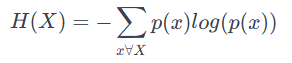

In machine learning, to optimize machine learning models, we measure the difference between the predicted probability distribution versus the target probability distribution for a given sample. For that, we use cross-entropy, an extension of entropy for two distributions:

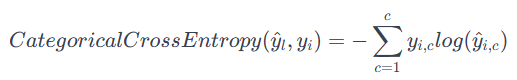

Finally, we defined perplexity as:

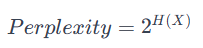

In [ ]:
class PerplexityMetric(tf.keras.metrics.Mean):

    def __init__(self, name='perplexity', **kwargs):
        super().__init__(name=name, **kwargs)
        self.cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False, reduction='none')

    def _calculate_perplexity(self, real, pred):

        # The next four lines zero out the padding from loss
        # calculations; this follows the logic from:
        # https://www.tensorflow.org/beta/tutorials/text/transformer#loss_ # and_metrics
        loss_ = self.cross_entropy(real, pred)
        # Calculating the perplexity steps:
        step1 = K.mean(loss_, axis=-1)
        perplexity = K.exp(step1)

        return perplexity

    def update_state(self, y_true, y_pred, sample_weight=None):
        perplexity = self._calculate_perplexity(y_true, y_pred)
        super().update_state(perplexity)

In [ ]:
lm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', PerplexityMetric()])

# 12. Training the model

In [ ]:
# lm_model.fit(train_ds, validation_data=valid_ds, epochs=50)
lm_model.fit(train_ds, validation_data=valid_ds, epochs=3)

Epoch 1/3
29/29 [==============================] - 208s 7s/step - loss: 5.4888 - accuracy: 0.0306 - perplexity: 277.0969 - val_loss: 5.1308 - val_accuracy: 0.0371 - val_perplexity: 170.4345
Epoch 2/3
29/29 [==============================] - 198s 7s/step - loss: 5.1571 - accuracy: 0.0340 - perplexity: 175.2786 - val_loss: 5.1139 - val_accuracy: 0.0372 - val_perplexity: 167.6606
Epoch 3/3
29/29 [==============================] - 199s 7s/step - loss: 5.1378 - accuracy: 0.0351 - perplexity: 171.9497 - val_loss: 5.1014 - val_accuracy: 0.0374 - val_perplexity: 165.6278


# 13. Evaluating the model

In [ ]:
lm_model.evaluate(test_ds)

4/4 [==============================] - 7s 2s/step - loss: 5.1253 - accuracy: 0.0369 - perplexity: 169.6174


[5.125256538391113, 0.03693033754825592, 169.6173858642578]